In [1]:
def __return_waypoints_ind():
    d = np.array([
    [ 65, -36],
    [ 56, -21],
    [ 66, -46],
    [ 58, -48],
    [ 67, -29],
    [ 61, -16],
    [ 45, -32],
    [ 71, -43],
    # [ 80, -52],
    # [ 68, -58],
    [ 65, -54],
    [ 48, -20],
    [ 64, -21],
    [ 46, -14]])
    return d


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
from helpers.accuracy_functions import destination_distance_l
import numpy as np
from tqdm import tqdm
from math import ceil

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 32
DENSE_LAYER_SIZE = 32
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 10
NOISE_STD = .1
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 10

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)


''' create the graph instance '''    
interest_points = __return_waypoints_ind()
g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

df_signals = scene_data.df_to_lst_realxy_mats()
g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)


[(array(['w7', 'd4'], dtype='<U2'), [(71, -43), (82.0, -53.0)]),
 (array(['wb'], dtype='<U2'), [(46, -14)]),
 (array(['wb', 'd7'], dtype='<U2'), [(46, -14), (36.0, -3.0)]),
 (array(['d8', 'w6', 'w3', 'w8', 'd3'], dtype='<U2'),
  [(27.0, -9.0), (45, -32), (58, -48), (65, -54), (70.0, -61.0)]),
 (array(['d8'], dtype='<U2'), [(27.0, -9.0)]),
 (array(['d3', 'w8', 'w3', 'w6', 'd8'], dtype='<U2'),
  [(70.0, -61.0), (65, -54), (58, -48), (45, -32), (27.0, -9.0)]),
 (array(['w3'], dtype='<U2'), [(58, -48)]),
 (array(['d4', 'w7', 'w0', 'w4', 'wa', 'w5', 'd0'], dtype='<U2'),
  [(82.0, -53.0),
   (71, -43),
   (65, -36),
   (67, -29),
   (64, -21),
   (61, -16),
   (53.0, -6.0)]),
 (array(['d5', 'w4', 'w0', 'w7', 'd4'], dtype='<U2'),
  [(72.0, -24.0), (67, -29), (65, -36), (71, -43), (82.0, -53.0)]),
 (array(['d4', 'w7', 'w0', 'w4', 'wa', 'w5', 'd0'], dtype='<U2'),
  [(82.0, -53.0),
   (71, -43),
   (65, -36),
   (67, -29),
   (64, -21),
   (61, -16),
   (53.0, -6.0)]),
 (array(['d3', 'w8', 'w3',

In [4]:

''' time to create df datasets '''
extra_features_dict = {
    "all_points": None,
    "all_destinations": None,
    "n_destinations": 5,
    "n_points": 5,
    "n_connected_points_after" : 3
}

# # Load data in order to not need to do calculations again
with open("data/pickle/3_10/test.pickle", 'rb') as handle: #"data/pickle/ds_creation_d/bs1.pickle"
    my_ds_creation_dict = pickle.load(handle)

my_ds = TFDataSet.init_as_fixed_length(scene_data.traj_dataframe, graph=g, var_in_len=VARIABLE_INPUT_LENGTH, length_stride=LENGTH_STRIDE,
scale_list=["pos_x", "pos_y"], seq_in_length=SEQ_IN_LEN, label_length=SEQ_OUT_LEN,
extra_features_dict=extra_features_dict, noise_std=NOISE_STD, 
n_repeats=N_REPEATS, batch_size=BATCH_SIZE, ds_creation_dict=my_ds_creation_dict) #save_folder = "data/pickle/ds_creation_d/ds_7to17_inputLabels3_4_low_noise.pickle"


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [5]:
# ''' time for some model training '''

# my_trainer = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
# my_trainer.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
# NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=[], 
# var_time_len=VARIABLE_INPUT_LENGTH, size_dict=my_ds.size_dict)

# from datetime import datetime 

# folder_path = "data/model_weights/checkpoints/%s" % (datetime.now().strftime("%d_%m_%Y__%H_%M"))
# save_path = os.path.join(folder_path, "model_3_4_wo_dests.pickle")            
# if not os.path.exists(folder_path):
#     os.mkdir(folder_path)
# my_trainer.compile_and_fit2(my_ds.tf_ds_dict["train"], my_ds.tf_ds_dict["val"], save_path=save_path)

In [6]:
# Load the 2 models (with and without destination included as a feature)

In [7]:
''' or some model loading '''

# # first without epistemic
# model_path = "data/model_weights/checkpoints/3_10_without_epi/model.pickle"

# my_trainer_wo_epi = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
# my_trainer_wo_epi.LSTM_one_shot_predictor_named_i(my_ds, 32, 32, 
# NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], 
# var_time_len=VARIABLE_INPUT_LENGTH, size_dict=my_ds.size_dict, epistemic=False, dropout_rate=0.05)
# my_trainer_wo_epi.load_weights(model_path)

# and also one with epistemic
model_path = "data/model_weights/checkpoints/3_10_with_epi/model.pickle"

my_trainer_w_epi = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
my_trainer_w_epi.LSTM_one_shot_predictor_named_i(my_ds, 32, 32, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], 
var_time_len=VARIABLE_INPUT_LENGTH, size_dict=my_ds.size_dict, epistemic=True, dropout_rate=0.05)
my_trainer_w_epi.load_weights(model_path)

3
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='in_xy'), name='in_xy', description="created by layer 'in_xy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 3), dtype=tf.float32, name='all_destinations'), name='all_destinations', description="created by layer 'all_destinations'")


In [34]:
pred_w_epi[0:1, :, :, :].shape

TensorShape([1, 15, 10, 2])

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/bram/anaconda3/envs/thesis_basic/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/home/bram/anaconda3/envs/thesis_basic/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/home/bram/anaconda3/envs/thesis_basic/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/home/bram/anaconda3/envs/thesis_basic/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 497, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/home/bram/anaconda3/envs/thesis_basic/lib/p

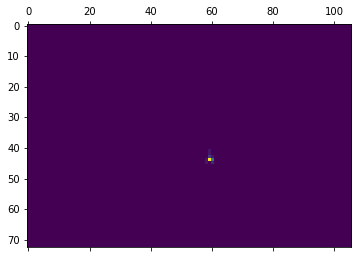

In [39]:
plt.matshow(grid_out)

In [49]:
total_probs/num_probs_incl


array([0.33171549, 0.28236701, 0.22567843, 0.15483563, 0.12406456,
       0.09566049, 0.08590556, 0.06971907,        nan,        nan])

In [40]:
num_probs_incl

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
''' Calculate KPIs for the whole test data set '''
# set up values where 
num_predicted_batches = 0.
total_w_dest = [0.] * len(g.destination_names)
total_wo_dest = [0.] * len(g.destination_names)

test_ds = my_ds.tf_ds_dict["test"]

total_probs = np.zeros(10)
num_probs_incl = np.zeros(10)

for batch in tqdm(iter(test_ds)):
    batch_in = batch[0]
    batch_out = my_ds.normer.scale_tensor(batch[1], "denormalize", "out") 

    # do prediction with epistemic (batch, num of epi pred, timesteps, x/y)???
    pred_w_epi = my_trainer_w_epi.predict_repetitively_dict_epi_adapted(batch_in, False, 10, False, 35)
    # print(pred_w_epi)
    # print(pred_w_epi.shape)
    # # expanded with 1 destination in first axis
    # pred_w_epi_exp = tf.expand_dims(pred_w_epi, axis=0) 
    print(pred_w_epi.shape)
    # for each element in the batch
    bs = pred_w_epi.shape[0]
    batch_prob_list = []
    for i in range(bs):

        this_epi_prediction = pred_w_epi[i:(i+1),:,:,:]

        print(this_epi_prediction.shape)
        this_label = batch_out[i, :, :]
        for point, point_index in zip(this_label, range(len(this_label))):
            # get results into grid
            grid_resolution = 3
            grid_out, _, grid_limits = scene_data.get_aggregated_output_probs(this_epi_prediction[:,:,point_index:(point_index+1),:], {0:1}, 
            grid_resolution)

            # unpack grid_limits
            x_min = grid_limits[0]
            x_max = grid_limits[1]
            y_min = grid_limits[2]
            y_max = grid_limits[3]

            # Create grid matrix        
            width = ceil((x_max-x_min)/grid_resolution)
            height = ceil((y_max-y_min)/grid_resolution)

            # get probabilities by comparing label to the grid
            # basically: get grid coordinate for each prediction and add the value of it to a list
            
            try:
                grid_x, grid_y = scene_data.find_grid_indices(point[0], point[1], x_min, y_min, grid_resolution)
                
                total_probs[point_index] += grid_out[grid_y, grid_x]
                num_probs_incl[point_index] += 1

            except:
                print("Point %s of the label was out of bound with coordinates (%.1f, %.1f)." % (point_index, point[0], point[1]))


    #     print(total_probs)
    # print("Batch: %s" % (total_probs/num_probs_incl))


 

print("With destination: %s"%[el/num_predicted_batches for el in total_w_dest])
print("Without destination: %s"%[el/num_predicted_batches for el in total_wo_dest])



0it [00:00, ?it/s]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


1it [00:03,  3.30s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


2it [00:06,  3.28s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the gri

3it [00:09,  3.28s/it]

Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of 

4it [00:13,  3.26s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. 

5it [00:16,  3.17s/it]

Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


6it [00:19,  3.09s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


7it [00:22,  3.09s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


8it [00:24,  3.00s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


9it [00:27,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


10it [00:30,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


11it [00:33,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


12it [00:36,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. 

13it [00:39,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a g

14it [00:42,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


15it [00:45,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


16it [00:48,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


17it [00:51,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


18it [00:54,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


19it [00:57,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a g

20it [01:00,  2.92s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a g

21it [01:03,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a g

22it [01:06,  2.96s/it]

Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of 

23it [01:08,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36

24it [01:11,  2.97s/it]

Prediction out of the grid. (13,27) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (14,27) for a grid size of (36,25)
Prediction out of the grid. (14,27) for a grid size of (36,25)
Prediction out of the grid. (14,28) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (12,27) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (12,27) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (13,29) for a grid size of (36,25)
Prediction out of the grid. (13,28) for a grid size of (36,25)
Prediction out of the grid. (13,29) for a grid size of (36,25)
Prediction out of the grid. (13,29) for a grid size of 

25it [01:14,  2.97s/it]

Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (17,27) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the gri

26it [01:17,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


27it [01:20,  2.97s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36

28it [01:23,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


29it [01:26,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


30it [01:29,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


31it [01:32,  2.99s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


32it [01:35,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the gri

33it [01:38,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


34it [01:41,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


35it [01:44,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


36it [01:47,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


37it [01:50,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a g

38it [01:53,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36

39it [01:56,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


40it [01:59,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


41it [02:02,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


42it [02:05,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


43it [02:08,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


44it [02:11,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


45it [02:13,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


46it [02:16,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction

47it [02:19,  2.96s/it]

Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (14,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of 

48it [02:22,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


49it [02:25,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


50it [02:28,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


51it [02:31,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


52it [02:34,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


53it [02:37,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


54it [02:40,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


55it [02:43,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


56it [02:46,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


57it [02:49,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


58it [02:52,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


59it [02:55,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


60it [02:58,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a g

61it [03:01,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


62it [03:04,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


63it [03:07,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


64it [03:10,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


65it [03:13,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. 

66it [03:16,  2.98s/it]

Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,28) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (15,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of 

67it [03:18,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


68it [03:21,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


69it [03:24,  2.99s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


70it [03:27,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


71it [03:30,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


72it [03:33,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


73it [03:36,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


74it [03:39,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


75it [03:42,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


76it [03:45,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. 

77it [03:48,  2.95s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


78it [03:51,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


79it [03:54,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


80it [03:57,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


81it [04:00,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


82it [04:03,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


83it [04:06,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


84it [04:09,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


85it [04:11,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


86it [04:14,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


87it [04:17,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


88it [04:20,  2.93s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


89it [04:23,  2.90s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


90it [04:26,  2.88s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


91it [04:29,  2.88s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


92it [04:32,  2.89s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


93it [04:35,  2.91s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


94it [04:38,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


95it [04:40,  2.91s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


96it [04:43,  2.90s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


97it [04:46,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


98it [04:49,  2.90s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


99it [04:52,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction

100it [04:55,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


101it [04:58,  2.94s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


102it [05:01,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


103it [05:04,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


104it [05:07,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


105it [05:10,  2.98s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


106it [05:13,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


107it [05:16,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


108it [05:19,  2.92s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


109it [05:21,  2.92s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


110it [05:25,  3.12s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


111it [05:28,  3.19s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


112it [05:31,  3.13s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


113it [05:34,  3.05s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


114it [05:37,  3.06s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


115it [05:40,  2.99s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


116it [05:43,  2.94s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


117it [05:46,  2.93s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


118it [05:49,  2.91s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


119it [05:52,  2.90s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


120it [05:54,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


121it [05:57,  2.88s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


122it [06:00,  2.88s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


123it [06:03,  2.89s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


124it [06:06,  2.91s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


125it [06:09,  2.89s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


126it [06:12,  2.89s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


127it [06:15,  2.88s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


128it [06:18,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


129it [06:21,  2.90s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


130it [06:23,  2.87s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


131it [06:26,  2.87s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


132it [06:29,  2.89s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


133it [06:32,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


134it [06:36,  3.28s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


135it [06:40,  3.53s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


136it [06:45,  3.71s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


137it [06:49,  3.83s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


138it [06:53,  3.86s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


139it [06:56,  3.59s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


140it [06:59,  3.42s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


141it [07:02,  3.29s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


142it [07:04,  3.17s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


143it [07:07,  3.11s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


144it [07:10,  3.06s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


145it [07:13,  3.04s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


146it [07:16,  3.01s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


147it [07:19,  3.01s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36

148it [07:22,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


149it [07:25,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a g

150it [07:28,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


151it [07:31,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


152it [07:34,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


153it [07:37,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (14,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. 

154it [07:40,  3.00s/it]

Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (15,28) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (14,27) for a grid size of (36,25)
Prediction out of the grid. (18,26) for a grid size of (36,25)
Prediction out of the grid. (15,28) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (17,27) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of 

155it [07:43,  3.01s/it]

Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of 

156it [07:46,  3.01s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


157it [07:49,  2.99s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


158it [07:52,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


159it [07:55,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


160it [07:58,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


161it [08:01,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


162it [08:04,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


163it [08:07,  2.96s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


164it [08:10,  2.97s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


165it [08:13,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


166it [08:16,  2.97s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


167it [08:19,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. (15,27) for a grid size of (36,25)
Prediction out of the grid. 

168it [08:22,  2.98s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


169it [08:25,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


170it [08:28,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


171it [08:31,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the gri

172it [08:34,  3.01s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


173it [08:37,  2.99s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. 

174it [08:40,  2.98s/it]

Prediction out of the grid. (16,27) for a grid size of (36,25)
Prediction out of the grid. (17,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (15,28) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (15,29) for a grid size of (36,25)
Prediction out of the grid. (15,29) for a grid size of (36,25)
Prediction out of the grid. (15,29) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (16,28) for a grid size of (36,25)
Prediction out of the grid. (15,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
Prediction out of the grid. (16,29) for a grid size of (36,25)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10

175it [08:43,  2.97s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


176it [08:45,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


177it [08:49,  2.99s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


178it [08:52,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


179it [08:55,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


180it [08:58,  2.99s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


181it [09:00,  2.95s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


182it [09:03,  2.99s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


183it [09:07,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


184it [09:09,  2.98s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


185it [09:12,  2.97s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


186it [09:15,  3.01s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


187it [09:19,  3.01s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


188it [09:21,  2.99s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


189it [09:24,  2.96s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


190it [09:27,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


191it [09:30,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


192it [09:33,  3.00s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


193it [09:37,  3.03s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)


194it [09:40,  3.02s/it]

Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


195it [09:43,  3.01s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36

196it [09:46,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


197it [09:49,  3.00s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


198it [09:52,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


199it [09:55,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


200it [09:58,  3.04s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (15,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (15,26) for a grid size of (36,25)
Prediction out of the grid. (14,27) for a grid size of (36,25)
Prediction out of the gri

201it [10:01,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


202it [10:04,  3.04s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


203it [10:07,  3.04s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36

204it [10:10,  3.09s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


205it [10:13,  3.05s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


206it [10:16,  3.03s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a g

207it [10:19,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


208it [10:22,  3.02s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


209it [10:25,  2.99s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (16,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36,25)
Prediction out of the grid. (17,26) for a grid size of (36

210it [10:28,  3.00s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


211it [10:31,  3.13s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)


212it [10:35,  3.21s/it]

Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


213it [10:38,  3.14s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


214it [10:41,  3.11s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


215it [10:44,  3.06s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


216it [10:47,  3.05s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


217it [10:50,  3.02s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


218it [10:53,  3.19s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


219it [11:01,  4.43s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


220it [11:07,  5.01s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


221it [11:13,  5.44s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


222it [11:20,  5.78s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


223it [11:25,  5.54s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


224it [11:29,  5.09s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction

225it [11:33,  4.65s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


226it [11:36,  4.32s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


227it [11:39,  4.02s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


228it [11:42,  3.68s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


229it [11:45,  3.48s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


230it [11:48,  3.31s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (16,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction

231it [11:51,  3.22s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


232it [11:54,  3.10s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


233it [11:57,  3.01s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


234it [12:00,  3.05s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


235it [12:04,  3.30s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (17,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the grid. (18,25) for a grid size of (36,25)
Prediction out of the gri

236it [12:08,  3.49s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


237it [12:12,  3.59s/it]

(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


238it [12:15,  3.51s/it]

(1, 35, 10, 2)
(5, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)
(1, 35, 10, 2)


239it [12:19,  3.09s/it]


KeyboardInterrupt: 

In [30]:
''' time for some model predictions '''
my_predictor_w_dest = extended_predictor(g, my_trainer_w_dest, 1)

nxt_unsc, nxt_sc = my_ds.example_dict("test", "in_xy")

# Let's extract just one path to make visualisation clearer
unscaled_ex = dict(nxt_unsc[0]), nxt_unsc[1]
scaled_ex = dict(nxt_sc[0]), nxt_sc[1]
# let's get an example of length one
for key in unscaled_ex[0].keys():
    unscaled_ex[0][key] = tf.expand_dims(nxt_unsc[0][key][0], axis=0)
for key in scaled_ex[0].keys():
    scaled_ex[0][key] = tf.expand_dims(nxt_sc[0][key][0], axis=0)   

In [31]:
# Basic prediction, but repeated (one at a time)
#PROBLEM: input is scaled
assembled_output, destination_list, dest_prob_dict = my_predictor_w_dest.predict_to_destinations(input_dict=unscaled_ex[0], 
num_steps = 20, variable_len_input=VARIABLE_INPUT_LENGTH, num_predictions=15, norm_probs=True, abs_probs=False)
# Epistemic uncertainty prediction
